#CEIA - IIA - TP2: Regresión del valor de valor medio de casas en distritos de California (20Co2025)

## Grupo 1 - 
### Miembros:
- Martín Brocca <martinbrocca@gmail.com>
- Emiliano Iparraguirre <emiliano.iparraguirre22@gmail.com>
- Natalia Espector <nataliaespector@gmail.com>
- Agustín Lopez Fredes <agustin.lopezfredes@gmail.com>
- Fernando Martinez <fgmartinez1989@gmail.com>

### Tareas y preguntas a resolver:

1. Obtener la correlación entre los atributos y entre los atributos y el target. ¿Qué atributo tiene mayor correlación lineal con el target? ¿Cuáles atributos parecen estar más correlacionados entre sí? Se pueden obtener los valores de correlación o graficarlos directamente utilizando un mapa de calor.
2. Graficar los histogramas de los diferentes atributos y el target. ¿Qué tipo de forma tienen los histogramas? ¿Se observa alguna forma de campana que sugiera que los datos provienen de una distribución gaussiana, sin realizar pruebas de hipótesis?
3. Calcular la regresión lineal utilizando todos los atributos. Con el conjunto de entrenamiento, calcular la varianza total del modelo y la varianza explicada por el modelo. ¿Está el modelo capturando el comportamiento del target? Expanda su respuesta.
4. Calcular las métricas de MSE, MAE y R² para el conjunto de evaluación.
5. Crear una regresión de Ridge. Usando validación cruzada de 5 folds y tomando como métrica el MSE, calcular el mejor valor de α, buscando entre [0, 12.5]. Graficar el valor de MSE versus α.
6. Comparar entre la regresión lineal y la mejor regresión de Ridge los resultados obtenidos en el conjunto de evaluación. ¿Cuál de los dos modelos da mejores resultados (usando MSE y MAE)? Conjeturar por qué el modelo que da mejores resultados mejora. ¿Qué error se puede haber reducido?


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge

sns.set()

In [27]:
# comprobar que el dataset se cargó correctamente:
california_housing = fetch_california_housing()
display(california_housing)

{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]]),
 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]),
 'frame': None,
 'target_names': ['MedHouseVal'],
 'feature_names': ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 'DESCR': '.. _california_housing_dataset:\n

In [28]:
#separamos la data del target:
x = california_housing.data
y = california_housing.target

In [29]:

# Pasar a Pandas para el manejo
x = pd.DataFrame(x, columns=california_housing['feature_names'])
y = pd.Series(y, name=california_housing['target_names'][0])

df_california = pd.concat([x, y], axis=1)

In [30]:
# leer el dataset
x.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [31]:
# leer el dataset
y.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

In [32]:
df_california.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [33]:
df_california.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [34]:
#verifico si hay nulls:
df_california.isnull().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

1. ### Obtener la correlación entre los atributos y entre los atributos y el target. ¿Qué atributo tiene mayor correlación lineal con el target? ¿Cuáles atributos parecen estar más correlacionados entre sí? Se pueden obtener los valores de correlación o graficarlos directamente utilizando un mapa de calor.

In [35]:
#Analicemos la correlaccion mediante Pandas
correlation_matrix = df_california.corr()
correlation_matrix

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.688075
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,0.105623
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.151948
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.046701
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,-0.024650
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476,-0.023737
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664,-0.144160
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000,-0.045967
MedHouseVal,0.688075,0.105623,0.151948,-0.046701,-0.024650,-0.023737,-0.144160,-0.045967,1.000000


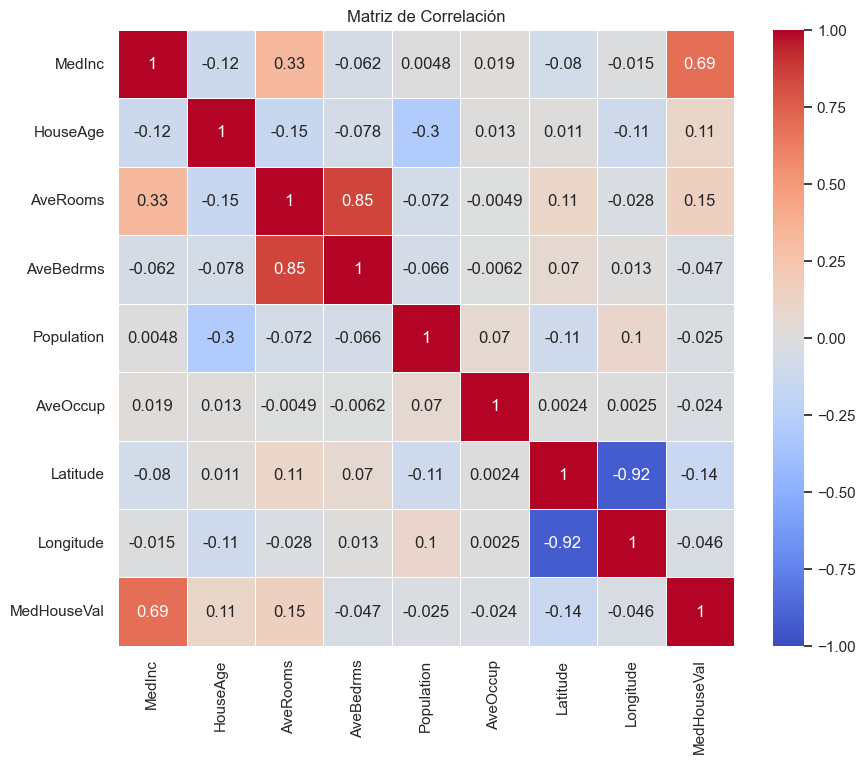

In [36]:
# Crear el heatmap
plt.figure(figsize=(10, 8))  
sns.heatmap(correlation_matrix, 
            annot=True,  
            cmap='coolwarm',  
            vmin=-1, vmax=1,  
            center=0,  
            square=True,  
            linewidths=0.5)  
plt.title('Matriz de Correlación')  
plt.show()

Se observa una fuerte correlacion entre MediaInc (ingreso medio) y MedHouseVal (valor promedio de casa), lo que indica que a medida que el ingreso promedio aumenta, 
también aumenta el valor de la casa. 
El número de habitaciones tiene una correlación con la cantidad de dormitorios.

2. ### Graficar los histogramas de los diferentes atributos y el target. ¿Qué tipo de forma tienen los histogramas? ¿Se observa alguna forma de campana que sugiera que los datos provienen de una distribución gaussiana, sin realizar pruebas de hipótesis?

In [37]:
df_california.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


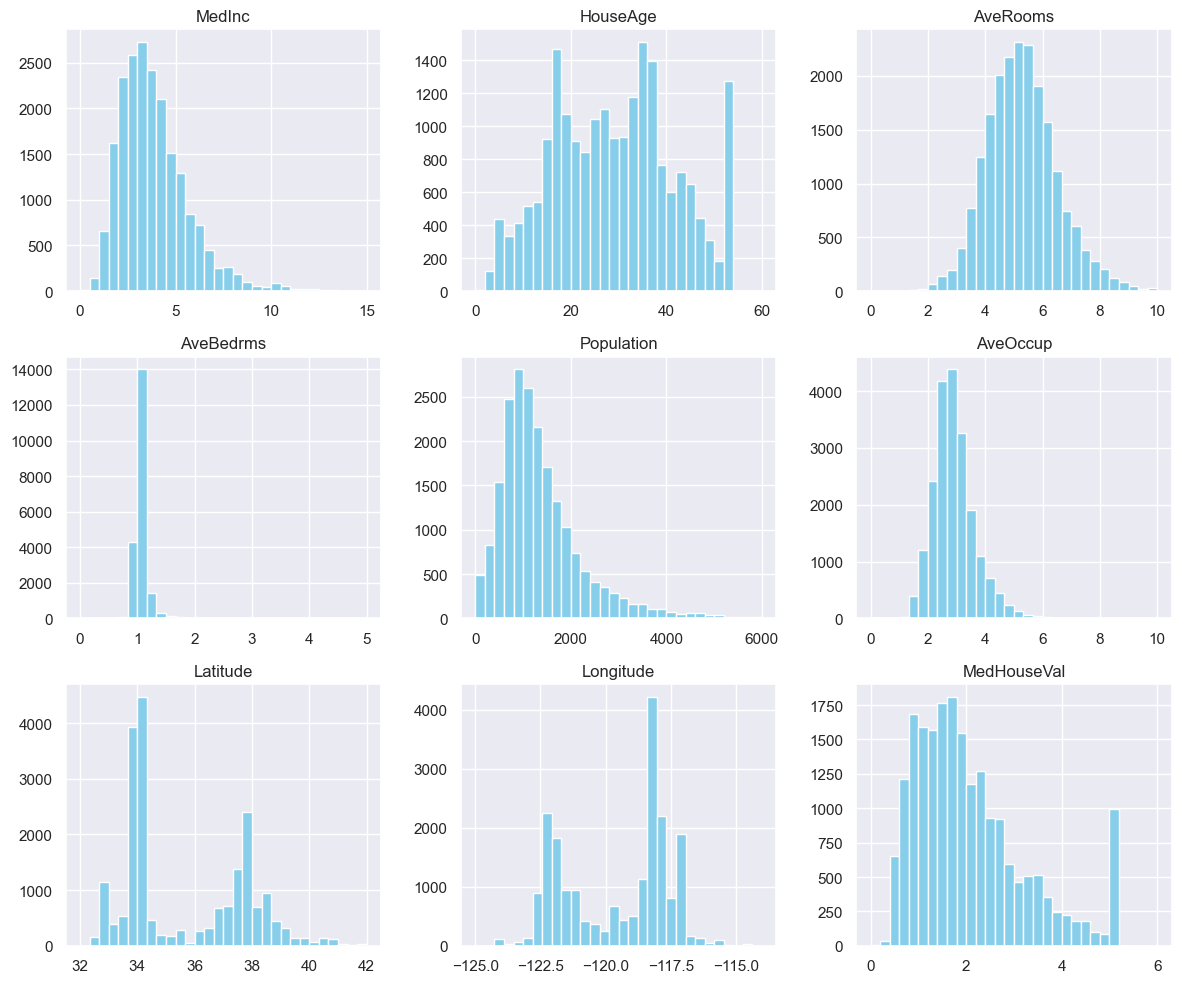

In [38]:
# En esta version de los histogramas corrijo los rangos de cada variable para que no pase lo que se en el grafico de las habitaciones 

fig, axes = plt.subplots(3, 3, figsize=(12, 10))  # 3x3 para 9 columnas
axes = axes.flatten()  # Convierte la matriz de ejes en una lista plana

# Rangos personalizados para cada columna 
ranges = {
    'MedInc': (0, 15),        # Ingreso medio
    'HouseAge': (0, 60),      # Edad de casas
    'AveRooms': (0, 10),      # Habitaciones (limitamos outliers)
    'AveBedrms': (0, 5),      # Dormitorios (limitamos outliers)
    'Population': (0, 6000),  # Población 
    'AveOccup': (0, 10),      # Ocupantes por hogar
    'Latitude': (32, 42),     # Latitud de California
    'Longitude': (-125, -114),# Longitud de California
    'MedHouseVal': (0, 6)     # Valor medio en $100k
}

# Crear histogramas con rangos personalizados
for i, col in enumerate(df_california.columns):
    df_california[col].hist(bins=30, range=ranges[col], ax=axes[i], color='skyblue')
    axes[i].set_title(col)
    axes[i].set_xlabel('')  # Opcional: quita etiquetas de ejes si prefieres

plt.tight_layout()
plt.show()




### MediaInc
El histograma muestra que la mayoria de las casas tienen ingresos relativamente bajos, ya que la gráfica se encuentra sesgada a la izquierda. 
### HouseAge
La mayoria de las casas tienen entre 20 y 40 años.
### AveRooms
El histograma muestra características típicas de una distribución gaussiana, como un pico central alrededor del cual se agrupan la mayoria de los datos y una forma unimodal, sin embargo
existe un leve sesgo hacia la derecha, y la presencia de outliers que afectan esta distribución. La distribución sugiere que la mayoria de las casas tienen entre 4 y 6 habitaciones.
### AveBedrms
Tiene un comportamiento similar a AveRooms.
### AveOccup 
La mayoria de las casas tienen entre 2 y 4 ocupantes, mostrando un sesgo a la derecha lo que sugiere que hay casas con un número mayor de ocupantes.
### MedHouseVal 
Este histograma muestra la mayoría de las casas en el conjunto de datos tienen un valor relativamente bajo, con una fuerte concentración de propiedades por debajo de 2. Esto sugiere que en California hay muchas viviendas que son asequibles para la mayoría de los compradores. Sin embargo, también se pueden ver algunos valores altos, lo que indica que existen propiedades de lujo que, aunque son menos comunes, sí influyen en la percepción general del mercado.
### Latitude
La mayoría de los casas se concentran entre 32 y 37 grados.
Existen picos evidentes en ciertos rangos, particularmente alrededor de 34 y 36 grados. La forma de la distribución sugiere que hay áreas urbanas en esas latitudes específicas que tienen una mayor
concentración de casas. 
### Longitude
La mayoria de las casas se encuentran entre los -125 y -115 grados, con picos significativos entre -120 y -118. Al igual que con la latitud, este histograma sugiere que la mayoria de las casas
estan ubicadas en áreas geográficas especificas dentro de California. Esto significa que hay zonas urbanas o áreas muy representativas en el conjunto de datos. 
### Population
El histograma revela que la mayoría de la población en el conjunto de datos se concentra entre 750 y 1500 habitantes. A medida que observamos desde 0 hasta 750, la gráfica muestra un crecimiento constante, alcanzando su pico alrededor de 1000 antes de comenzar a descender hacia 1500. El leve sesgo hacia la derecha sugiere que existen algunas áreas con una población notablemente alta.





3. ### Calcular la regresión lineal utilizando todos los atributos. Con el conjunto de entrenamiento, calcular la varianza total del modelo y la varianza explicada por el modelo. ¿Está el modelo capturando el comportamiento del target? Expanda su respuesta.


Separamos en datos de train y test usando un split de 30% para test y 70% para entrenamiento

In [39]:
# Separamos el dataset en el conjunto de entrenamiento y el de evaluación, quedándonos con el 30% para el dataset de evaluación:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Datos de train y de test
print("Dimensión de X_train:",X_train.shape)
print("Valores de y_train:",y_train.size)
print("Dimensión de X_test:",X_test.shape)
print("Valores de y_test:",len(y_test)) 

Dimensión de X_train: (14448, 8)
Valores de y_train: 14448
Dimensión de X_test: (6192, 8)
Valores de y_test: 6192


In [40]:
# Creamos el pipeline con StandardScaler y regresión lineal
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),       # Escalado estándar
    ('regressor', LinearRegression())   # Modelo de regresión lineal
])

pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [41]:
pipeline.fit(X_train, y_train)
pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [42]:
print(f"El valor de la intersección de la recta es {np.round(pipeline.named_steps['regressor'].intercept_, 2)}")
print(f"Los valores de los coeficientes de la recta son {np.round(pipeline.named_steps['regressor'].coef_, 2)}")

print(f"Las columnas son {x.columns.tolist()}")

El valor de la intersección de la recta es 2.07
Los valores de los coeficientes de la recta son [ 0.85  0.12 -0.3   0.35 -0.   -0.04 -0.89 -0.87]
Las columnas son ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


Se observa que la columna MedInc, que arrojaba la mayor correlación, tiene el coeficiente más alto. Resulta llamativo los coeficientes negativos pero de valor absoluto alto de Latitud y Longitud, que en la correlación se había mostrado cerca de 0

Para obtener la varianza total y la varianza explicada por el modelo, usando el conjunto de entrenamiento, parto prediciendo los valores de y

In [43]:
y_pred_train = pipeline.predict(X_train)
y_pred_train

# Varianza total del modelo
sst = np.sum((y_train - np.mean(y_train)) ** 2)

# Varianza no explicada (SSE)
sse = np.sum((y_train - y_pred_train) ** 2)

# Varianza explicada por el modelo (SSR)
ssr = sst - sse

print(f"La varianza total del conjunto de entrenamiento es {sst}")
print(f"La varianza total explicada por el modelo es {ssr}")
print(f"El R2 es {np.round(ssr/sst, 4)}")

La varianza total del conjunto de entrenamiento es 19355.92748251429
La varianza total explicada por el modelo es 11794.456461225038
El R2 es 0.6093


El modelo explica aproximadamente el 60% de la varianza total. Al no ser posible graficar la recta de regresión vs los datos en un gráfico 2D al tener 8 variables, graficamos los datos reales vs la predicción. A medida que los puntos se alejan de la recta diagonal implica que el error es mayor (si están por encima de la recta, el modelo está sobreestimando el valor real y viceversa)

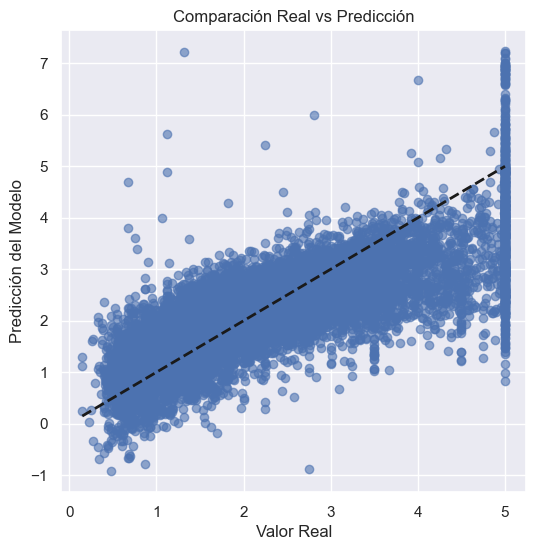

In [54]:
y_pred = pipeline.predict(X_train)

plt.figure(figsize=(6, 6))
plt.scatter(y_train, y_pred, alpha=0.6, color='b')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.xlabel("Valor Real")
plt.ylabel("Predicción del Modelo")
plt.title("Comparación Real vs Predicción")
plt.grid(True)
plt.show()

Observamos que el modelo tiende a sobreestimar los valores bajos (por ej para valor real 1 hay mayor cantidad de puntos por encima de la recta que por debajo), y a subestimar los valores los valores más elevados (por ej  en 4). Por otro lado para el valor de 5, hay una enorme dispersión, indicando una gran cantidad de puntos que el modelo subestima y también que sobreestima, por lo que no logra captar correctamente el comportamiento en esta zona.

4. ### Calcular las métricas de MSE, MAE y R² para el conjunto de evaluación.


In [44]:
from sklearn.metrics import (r2_score, mean_absolute_error, 
                             mean_squared_error, root_mean_squared_error, 
                             mean_absolute_percentage_error)

y_pred_test = pipeline.predict(X_test)

r2 = r2_score(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = root_mean_squared_error(y_test, y_pred_test)
mape = mean_absolute_percentage_error(y_test, y_pred_test)

print("R-cuadrado en test:", round(r2, 3))
print("Error absoluto medio:", round(mae, 3))
print("Error cuadrático medio:", round(mse, 3))
print("Raíz de error cuadrático medio:", round(rmse, 3))
print(f"Error absoluto porcentual medio: {mape*100:.2f}%")

R-cuadrado en test: 0.596
Error absoluto medio: 0.527
Error cuadrático medio: 0.531
Raíz de error cuadrático medio: 0.728
Error absoluto porcentual medio: 31.75%


Para comparar con un baseline, utilizamos el promedio de y_train para predecir en el conjunto de test, es decir, vamos a predecir que todas las casas van a tener un valor igual a la media del conjunto de entrenamiento

In [45]:
mean_profit = np.mean(y_train)

y_pred_baseline = np.full_like(y_test, mean_profit)

r2_baseline = r2_score(y_test, y_pred_baseline)
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
mse_baseline = mean_squared_error(y_test, y_pred_baseline)
rmse_baseline = root_mean_squared_error(y_test, y_pred_baseline)
mape_baseline = mean_absolute_percentage_error(y_test, y_pred_baseline)

print("R-cuadrado en test:", round(r2_baseline, 3))
print("Error absoluto medio:", round(mae_baseline, 3))
print("Error cuadrático medio:", round(mse_baseline, 3))
print("Raiz de error cuadrático medio:", round(rmse_baseline, 3))
print(f"Error absoluto porcentual medio: {mape_baseline*100:.2f}%")

R-cuadrado en test: -0.0
Error absoluto medio: 0.906
Error cuadrático medio: 1.313
Raiz de error cuadrático medio: 1.146
Error absoluto porcentual medio: 62.29%


Se observa que el modelo entrenado es superior al base. Por ej la métrica de error porcentual (MAPE) arroja un valor de la mitad respecto al modelo base

5. ### Crear una regresión de Ridge. Usando validación cruzada de 5 folds y tomando como métrica el MSE, calcular el mejor valor de α, buscando entre [0, 12.5]. Graficar el valor de MSE versus α.


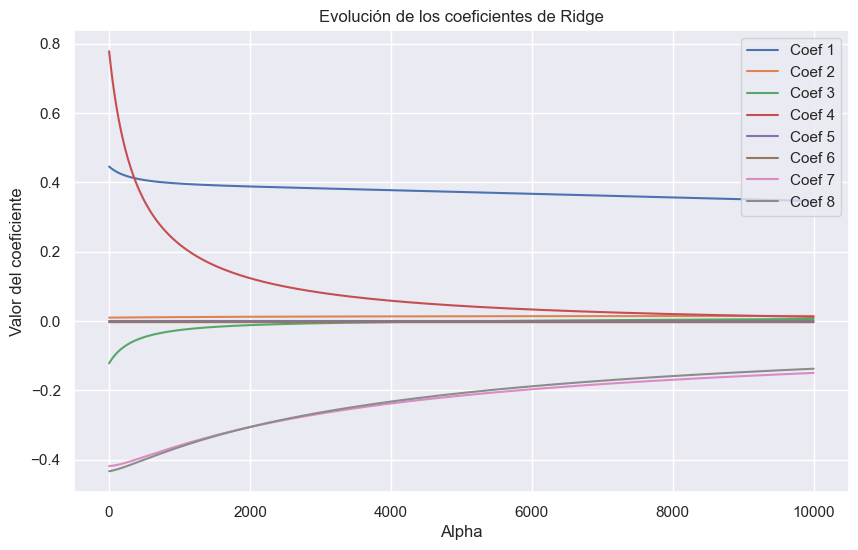

In [46]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import LinearRegression
# Ajustamos la dimensión a 8 columnas (número de atributos en X_train)
coeffs_lasso = np.zeros([5000, 8])  # 5000 filas (alphas), 8 columnas (coeficientes)
coeffs_ridge = np.zeros([5000, 8])

alpha_array_plot = np.arange(0, 10000, 2)  # 5000 valores de alpha

# Calculamos los coeficientes para diferentes valores de alpha
for index, alpha in enumerate(alpha_array_plot):
    # Creamos los modelos
    lasso_model = Lasso(alpha=alpha)
    ridge_model = Ridge(alpha=alpha)

    # Si alpha es cero, usamos LinearRegression
    if index == 0:
        lasso_model = LinearRegression()
        ridge_model = LinearRegression()

    # Los entrenamos
    lasso_model.fit(X_train, y_train)
    ridge_model.fit(X_train, y_train)

    # Guardamos los coeficientes
    coeffs_lasso[index, :] = lasso_model.coef_.copy()
    coeffs_ridge[index, :] = ridge_model.coef_.copy()

# Graficar cómo cambian los coeficientes
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
for i in range(8):
    plt.plot(alpha_array_plot, coeffs_ridge[:, i], label=f'Coef {i+1}')
plt.xlabel('Alpha')
plt.ylabel('Valor del coeficiente')
plt.title('Evolución de los coeficientes de Ridge')
plt.legend()
plt.show()

Mejor alpha: 0.00, MSE: 0.5268


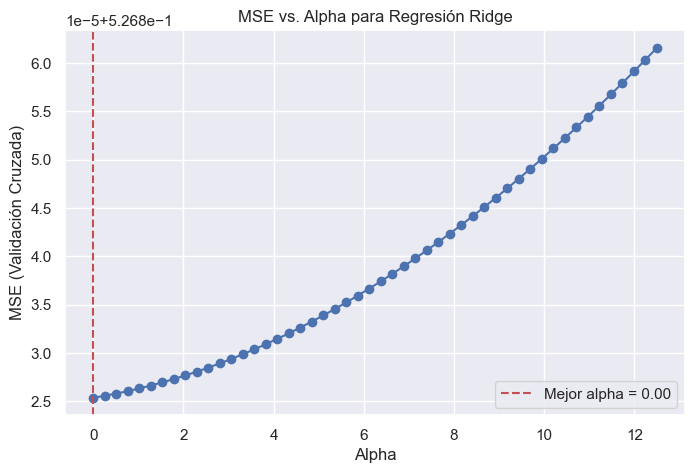

In [47]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Definimos los valores de alpha a probar
alpha_values = np.linspace(0, 12.5, 50)  # 50 puntos entre 0 y 12.5

# Lista para almacenar los MSE promedio
mse_scores = []

# Validación cruzada para cada alpha
for alpha in alpha_values:
    ridge_model = Ridge(alpha=alpha)
    # Calculamos el MSE negativo con validación cruzada (5 folds)
    scores = cross_val_score(ridge_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    # Convertimos a MSE positivo y promediamos
    mse_scores.append(-scores.mean())

# Encontramos el mejor alpha
best_alpha = alpha_values[np.argmin(mse_scores)]
print(f"Mejor alpha: {best_alpha:.2f}, MSE: {min(mse_scores):.4f}")

# Graficamos MSE vs. alpha
plt.figure(figsize=(8, 5))
plt.plot(alpha_values, mse_scores, marker='o', color='b')
plt.xlabel('Alpha')
plt.ylabel('MSE (Validación Cruzada)')
plt.title('MSE vs. Alpha para Regresión Ridge')
plt.axvline(x=best_alpha, color='r', linestyle='--', label=f'Mejor alpha = {best_alpha:.2f}')
plt.legend()
plt.show()

In [48]:
# Entrenamos el modelo final con el mejor alpha
best_ridge = Ridge(alpha=best_alpha)
best_ridge.fit(X_train, y_train)

Ridge(alpha=0.0)

## Version del jupyter del profesor

In [49]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

alpha_array = np.arange(0, 12.5, 0.25)

# Validación cruzada de 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Donde vamos a almacenar los errores
cv_ridge_errors = []
cv_lasso_errors = []

# Búsqueda del mejor alpha usando un loop
for alpha in alpha_array:
    fold_ridge_errors = []
    fold_lasso_errors = []

    # Realizar la validación cruzada
    for train_idx, val_idx in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx, :], X_train.iloc[val_idx, :]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
        # Crear y entrenar el modelo de Ridge
        ridge = Ridge(alpha=alpha)
        lasso = Lasso(alpha=alpha)
        if alpha == 0:
            ridge = LinearRegression()
            lasso = LinearRegression()
        
        ridge.fit(X_train_fold, y_train_fold)
        lasso.fit(X_train_fold, y_train_fold)

        # Hacer las predicciones sobre el fold de validación
        y_pred_ridge = ridge.predict(X_val_fold)
        y_pred_lasso = lasso.predict(X_val_fold)

        # Calcular el error cuadrático medio para el fold
        mse_ridge = mean_absolute_error(y_val_fold, y_pred_ridge)
        mse_lasso = mean_absolute_error(y_val_fold, y_pred_lasso)
        fold_ridge_errors.append(mse_ridge)
        fold_lasso_errors.append(mse_lasso)

    # Calcular el error medio para este alpha
    cv_ridge_errors.append(np.mean(fold_ridge_errors))
    cv_lasso_errors.append(np.mean(fold_lasso_errors))

# Mostramos cual es el mejor valor de alpha para cada caso
best_alpha_ridge = alpha_array[np.argmin(cv_ridge_errors)]
best_alpha_lasso = alpha_array[np.argmin(cv_lasso_errors)]
print(f"El mejor valor de alpha para Ridge es: {best_alpha_ridge}")
print(f"El mejor valor de alpha para Lasso es: {best_alpha_lasso}")

El mejor valor de alpha para Ridge es: 0.0
El mejor valor de alpha para Lasso es: 0.0


 6. ### Comparar entre la regresión lineal y la mejor regresión de Ridge los resultados obtenidos en el conjunto de evaluación. ¿Cuál de los dos modelos da mejores resultados (usando MSE y MAE)? Conjeturar por qué el modelo que da mejores resultados mejora. ¿Qué error se puede haber reducido?


La validación cruzada mostró que el mejor alpha para Ridge fue 0, indicando que la regularización no mejora el modelo sobre una regresión lineal simple. Esto sugiere que el dataset tiene suficiente tamaño y una relación señal-ruido adecuada, sin signos claros de sobreajuste que requieran penalización L2.

## Yapa: mostrar los datos del dataset en el mapa para ver donde estan las casas en cuestion

In [ ]:
import folium
import pandas as pd


# Creamos un mapa centrado en California
california_map = folium.Map(location=[36.7783, -119.4179], zoom_start=6)

# Definimos rangos y colores para MedHouseVal
def get_color(value):
    if value > 4:
        return 'darkred'
    elif value > 3:
        return 'red'
    elif value > 2:
        return 'orange'
    elif value > 1:
        return 'yellow'
    else:
        return 'green'

# Añadimos puntos al mapa con colores según el valor
for lat, lon, value in zip(df['Latitude'], df['Longitude'], df['MedHouseVal']):
    # Convertimos a float y manejamos NaN
    if pd.isna(lat) or pd.isna(lon) or pd.isna(value):
        continue  # Saltamos filas con valores nulos
    folium.CircleMarker(
        location=[float(lat), float(lon)],
        radius=5,
        color='gray',
        fill=True,
        fill_color=get_color(float(value)),
        fill_opacity=0.7,
        popup=f'Valor: {float(value):.2f} ($100k)'
    ).add_to(california_map)

# Añadimos una leyenda simplificada usando HTML directamente
legend_html = '''
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 150px; height: 150px; 
     background-color: rgba(255, 255, 255, 0.8);
     border: 2px solid grey; z-index:9999; font-size:14px;">
     <b>Valor Medio ($100k)</b><br>
     <i style="color:darkred;">●</i> > 4<br>
     <i style="color:red;">●</i> 3 - 4<br>
     <i style="color:orange;">●</i> 2 - 3<br>
     <i style="color:yellow;">●</i> 1 - 2<br>
     <i style="color:green;">●</i> 0 - 1
</div>
'''

california_map.get_root().html.add_child(folium.Element(legend_html))

# Mostrar el mapa en Jupyter -- Descomentar en local, porque sino no muestra en Github
# california_map